# Does player's sprints correlate to TotalxG?

# Correlation to xG

**Import dependencies and prepare dataset**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import export_graphviz
import graphviz

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.inspection import permutation_importance
from sklearn.feature_selection import mutual_info_regression
from sklearn.metrics import mean_squared_error,r2_score,mean_absolute_error

import statsmodels.api as sm
import shap

In [ ]:
full_games_dataset = pd.read_csv("/content/full_games_dataset.csv")
full_games_dataset = full_games_dataset.drop(['game_date','interval_duration','TotalxG','opponent_team_xG','xG_diff'],axis=1)
full_games_dataset = full_games_dataset.reset_index(drop=True)

In [ ]:
X = full_games_dataset.drop(columns=['xPts'])
y = full_games_dataset['xPts']
scaler = StandardScaler()

In [ ]:
def plot_scatter(df, target_col, variable_col):
    """
    Generates a scatter plot between the target column and a specified variable column.

    Args:
        df: pandas DataFrame.
        target_col: Name of the target column.
        variable_col: Name of the variable column to plot against the target.
    """
    plt.figure(figsize=(8, 6))
    sns.scatterplot(data=df, x=target_col, y=variable_col)
    plt.title(f'{variable_col} vs {target_col}')
    plt.xlabel(target_col)
    plt.ylabel(variable_col)
    plt.grid(True)
    if target_col == 'possession':
      plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: '{:.0%}'.format(x)))
      plt.xlabel('Possession (%)')
    plt.show()

## Vizualising the data

### Zones5/6 vs Possession

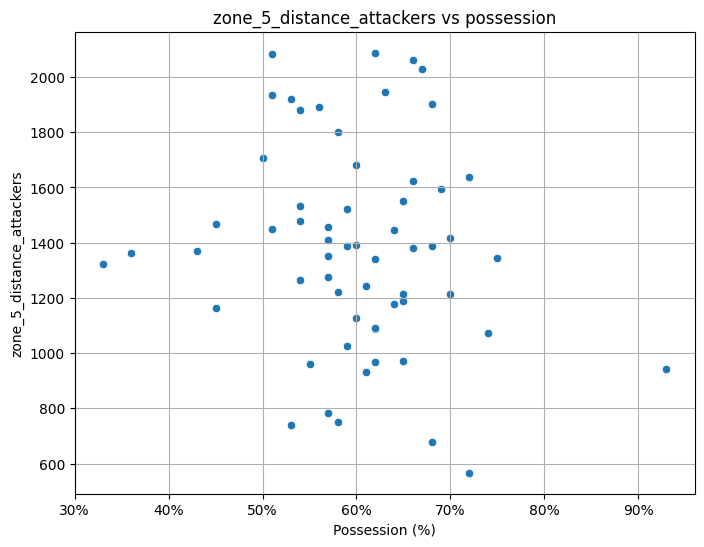

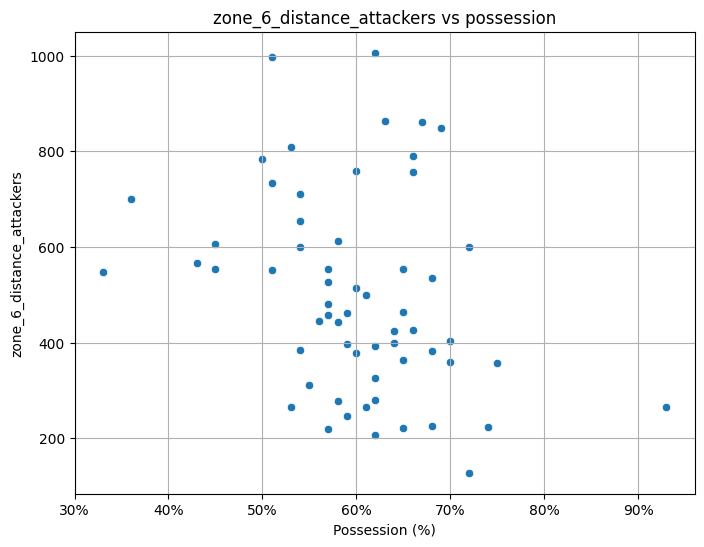

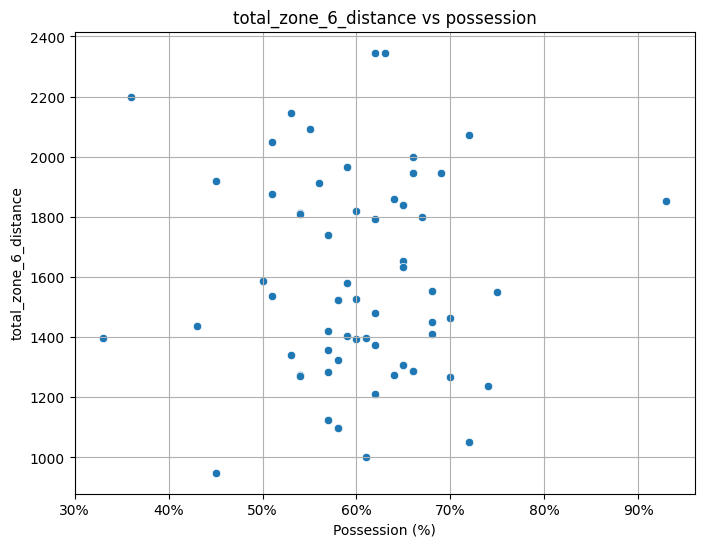

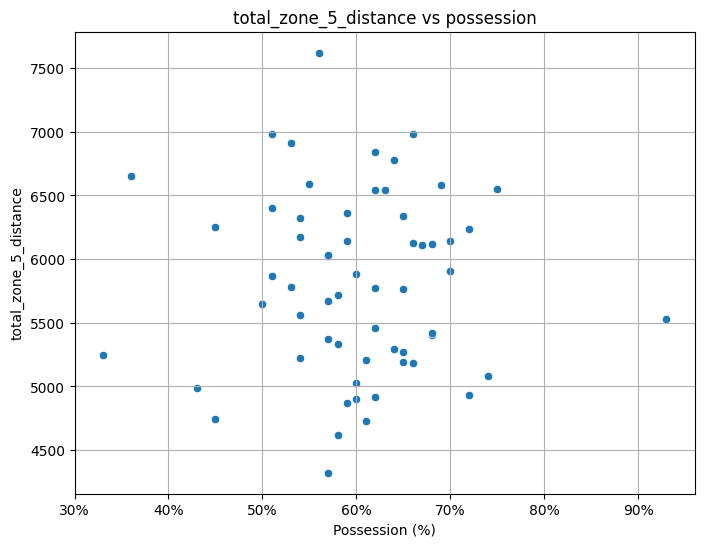

In [ ]:
plot_scatter(full_games_dataset, 'possession', 'zone_5_distance_attackers')
plot_scatter(full_games_dataset, 'possession', 'zone_6_distance_attackers')
plot_scatter(full_games_dataset, 'possession', 'total_zone_6_distance')
plot_scatter(full_games_dataset, 'possession', 'total_zone_5_distance')

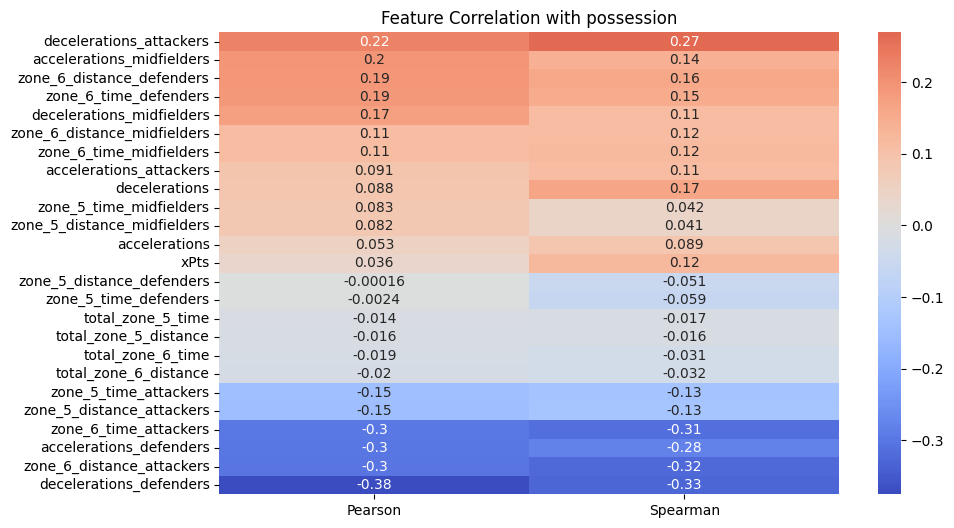

In [ ]:
Z = full_games_dataset.drop(columns=['possession'])
T = full_games_dataset['possession']
pearson_corr = Z.corrwith(T)
spearman_corr = Z.corrwith(T, method='spearman')
plt.figure(figsize=(10, 6))

# Combine Pearson and Spearman into a DataFrame and plot heatmap
corr_df = pd.DataFrame({
    'Pearson': pearson_corr,
    'Spearman': spearman_corr
})
sorted_features_corr = corr_df.reindex(corr_df['Pearson'].sort_values(ascending=False).index)
sns.heatmap(sorted_features_corr, annot=True, cmap="coolwarm", center=0)
plt.title("Feature Correlation with possession")
plt.show()

## Linear correlation

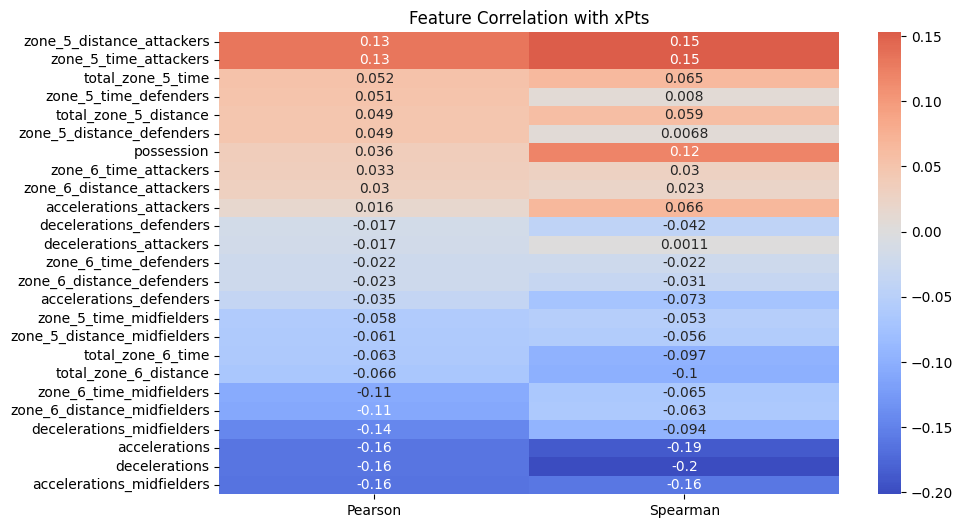

In [ ]:
# Pearson correlation
pearson_corr = X.corrwith(y)
spearman_corr = X.corrwith(y, method='spearman')
plt.figure(figsize=(10, 6))

# Combine Pearson and Spearman into a DataFrame and plot heatmap
corr_df = pd.DataFrame({
    'Pearson': pearson_corr,
    'Spearman': spearman_corr
})
sorted_features_corr = corr_df.reindex(corr_df['Pearson'].sort_values(ascending=False).index)
sns.heatmap(sorted_features_corr, annot=True, cmap="coolwarm", center=0)
plt.title("Feature Correlation with xPts")
plt.show()

We can observe that there is a significant positive correlation in both matrics between attackers sprints to total xG.
Also, in both matrics, there is a negative correlation between deceleration, especially midfilders decelerations to total xG which can point on a new thesis we didn't think about before.

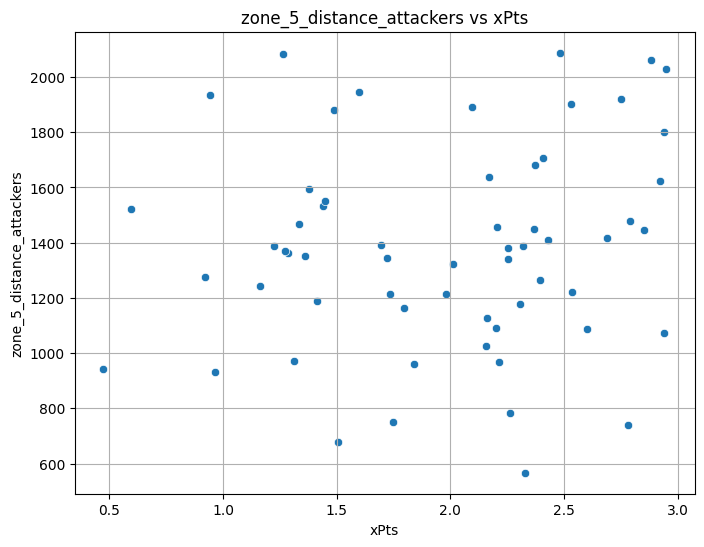

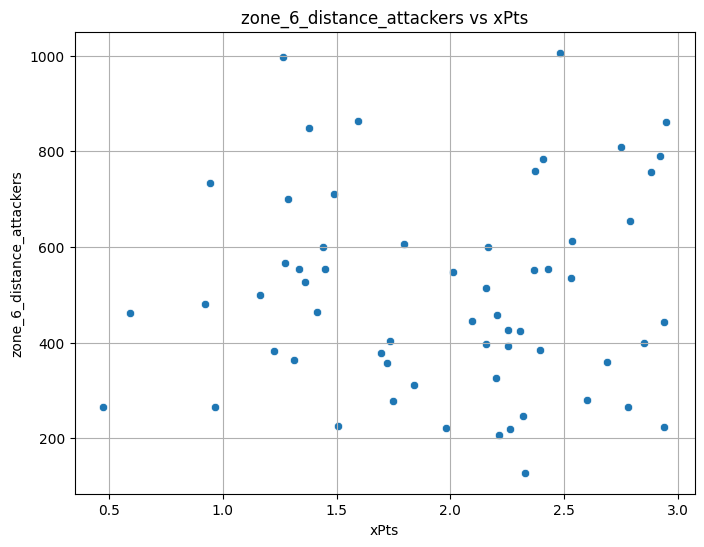

In [ ]:
plot_scatter(full_games_dataset, 'xPts', 'zone_5_distance_attackers')
plot_scatter(full_games_dataset, 'xPts', 'zone_6_distance_attackers')

## Mutual Information

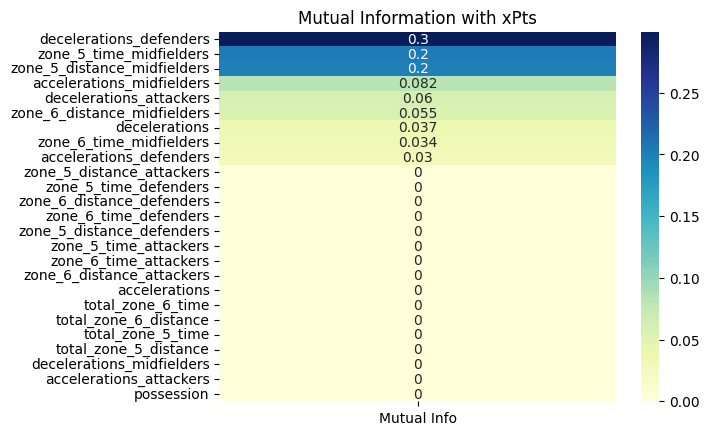

In [ ]:
# Mutual Information (non-linear dependency)
mi = mutual_info_regression(X, y)
mi_series = pd.Series(mi, index=X.columns)
sorted_mi = mi_series.sort_values(ascending=False)
sns.heatmap(sorted_mi.to_frame(name='Mutual Info'), annot=True, cmap="YlGnBu")
plt.title("Mutual Information with xPts")
plt.show()

This approach is able to catch non linear relations between features to the target, this metric strengthens our thesis about the relation between zone 5/6 sprints to total xG, especially attackers sprints.

## Least Squares coefficients and P-values

In [ ]:
cols_to_drop = [col for col in full_games_dataset.columns if 'distance' in col or 'total' in col]
X = X.drop(columns=cols_to_drop)
X = X.drop(['accelerations','decelerations'],axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)
model = sm.OLS(y, sm.add_constant(X_scaled))
results = model.fit()

# Create a summary table
coef_df = pd.DataFrame({
    'Feature': ['const'] + list(X.columns), # Add 'const' to the feature list
    'Coefficient': round(results.params,3),
    'P-value': round(results.pvalues,5)
}).sort_values(by='Coefficient', key=lambda x: np.abs(x), ascending=False)

coef_df




,Feature,Coefficient,P-value
const,const,1.974,0.00000
zone_5_time_attackers,zone_5_time_attackers,0.211,0.24347
decelerations_attackers,decelerations_attackers,-0.196,0.43648
accelerations_midfielders,accelerations_midfielders,-0.160,0.44122
zone_6_time_attackers,zone_6_time_attackers,-0.116,0.52564
accelerations_attackers,accelerations_attackers,0.109,0.67926
zone_5_time_midfielders,zone_5_time_midfielders,0.107,0.55303
zone_6_time_midfielders,zone_6_time_midfielders,-0.106,0.51983
zone_6_time_defenders,zone_6_time_defenders,-0.088,0.57201
zone_5_time_defenders,zone_5_time_defenders,0.084,0.59705


## Random Forest

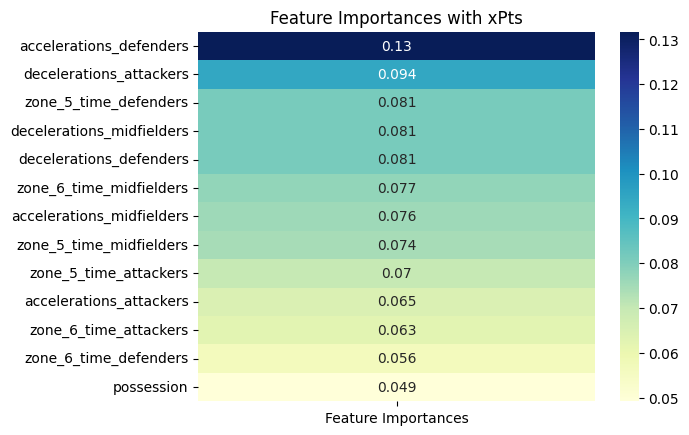

In [ ]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

rf = RandomForestRegressor(n_estimators=100, random_state=42,max_features=6)
rf.fit(X_train, y_train.to_numpy().ravel())

rf_importances = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)
sorted_importance = rf_importances.sort_values(ascending=False)
sns.heatmap(sorted_importance.to_frame(name='Feature Importances'), annot=True, cmap="YlGnBu")
plt.title("Feature Importances with xPts")
plt.show()

In [ ]:
r2 = r2_score(y_test, rf.predict(X_test))
mae = mean_absolute_error(y_test, rf.predict(X_test))
mse = mean_squared_error(y_test, rf.predict(X_test))
print(f"R2: {r2}")
print(f"MAE: {mae}")
print(f"MSE: {mse}")


R2: -0.07463228228760399
MAE: 0.6765977777777779
MSE: 0.6208252486333338


## SHAP analysis

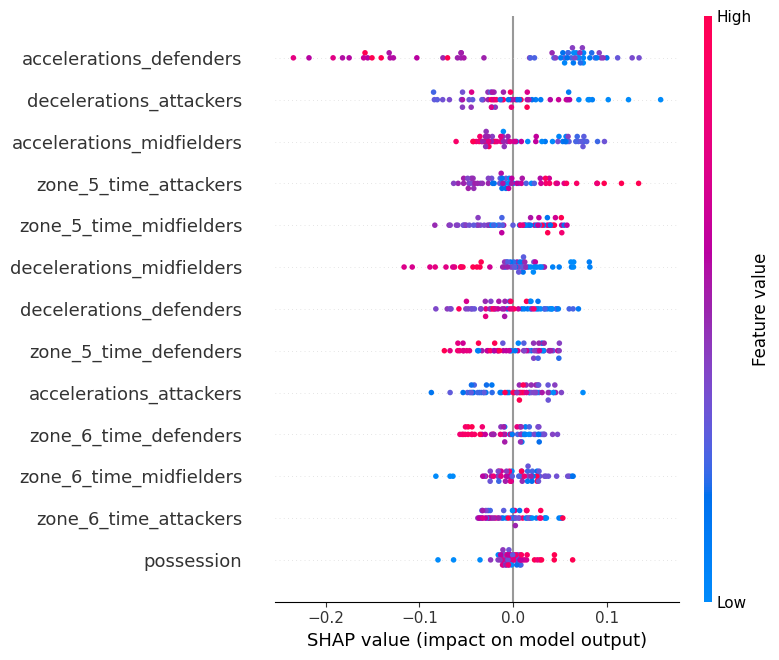

In [ ]:
explainer = shap.TreeExplainer(rf)
shap_values = explainer(X)  # explain on test set

# Summary plot (global feature importance)
shap.summary_plot(shap_values, X)


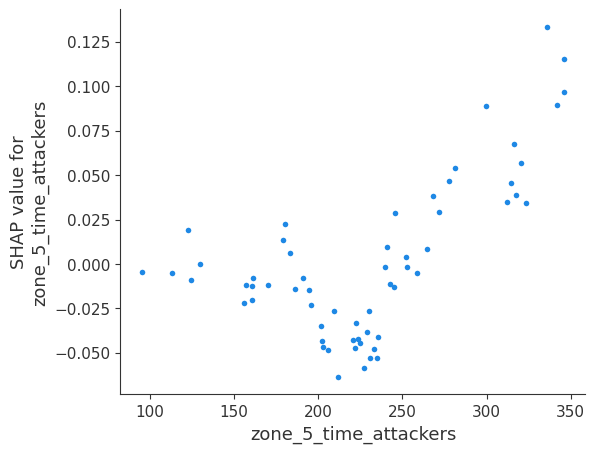

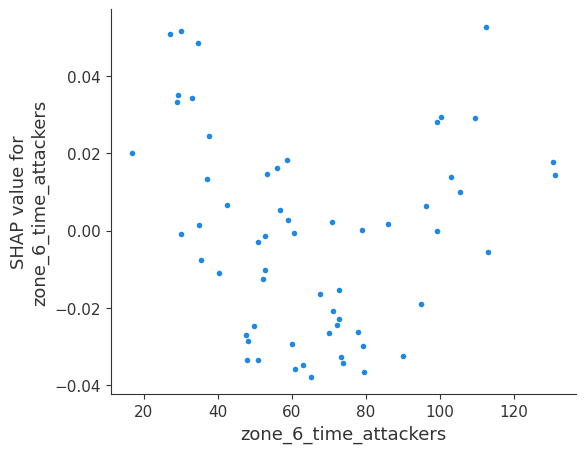

In [ ]:
shap.dependence_plot("zone_5_time_attackers", shap_values.values, X,interaction_index=None)
shap.dependence_plot("zone_6_time_attackers", shap_values.values, X,interaction_index=None)

The model learned that when attackers spend more time in high-intensity sprint zone (zone 5), it predicts better match outcomes - especially if those attackers are also performing many accelerations.

## Summary

In [ ]:
combined_df = pd.DataFrame({
    'Pearson': pearson_corr,
    'Spearman': spearman_corr,
    'Mutual_Info': mi_series,
    'Linear_Coefficient': coef_df.set_index('Feature').loc[X.columns, 'Coefficient'],
    'P-value': coef_df.set_index('Feature').loc[X.columns, 'P-value'],
    'RF_Importance': rf_importances,
    'Permutation_Importance': perm_importance_series
})

# Round values for readability
combined_df[['Pearson','Spearman','Mutual_Info','Linear_Coefficient','P-value',
             'RF_Importance','Permutation_Importance']] = combined_df[[
    'Pearson','Spearman','Mutual_Info','Linear_Coefficient','P-value',
    'RF_Importance','Permutation_Importance'
]].round(4)

# Sort by absolute Permutation Importance (validated)
combined_df = combined_df.reindex(
    combined_df['Permutation_Importance'].abs().sort_values(ascending=False).index
)

combined_df

,Pearson,Spearman,Mutual_Info,Linear_Coefficient,P-value,RF_Importance,Permutation_Importance
zone_5_time_midfielders,-0.0582,-0.0532,0.2040,0.107,0.5530,0.0744,-0.0722
accelerations_defenders,-0.0354,-0.0726,0.0302,-0.082,0.6247,0.1317,-0.0666
accelerations_midfielders,-0.1638,-0.1612,0.0815,-0.160,0.4412,0.0757,0.0544
zone_5_time_defenders,0.0505,0.0080,0.0000,0.084,0.5970,0.0813,-0.0437
zone_6_time_defenders,-0.0219,-0.0225,0.0000,-0.088,0.5720,0.0564,-0.0329
accelerations_attackers,0.0162,0.0659,0.0000,0.109,0.6793,0.0647,0.0297
zone_5_time_attackers,0.1329,0.1529,0.0000,0.211,0.2435,0.0700,-0.0294
possession,0.0360,0.1207,0.0000,0.079,0.5109,0.0492,-0.0123
decelerations_midfielders,-0.1449,-0.0938,0.0000,0.025,0.8987,0.0811,0.0119
decelerations_defenders,-0.0173,-0.0422,0.2994,0.009,0.9565,0.0811,0.0106
